In [5]:
import pandas as pd
import numpy as np

import os
import sys
sys.path.append(os.path.abspath('../'))

from src.data.utility import DataReader, BeerData

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Instantiate the custom data reader class
data_reader = DataReader()
# Load Raw Train Data
train_df = data_reader.read_data(BeerData.RAW)

### 1. View Original Data

In [7]:
train_df.info()
print("Raw Data Dimension", train_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB
Raw Data Dimension (1586614, 13)


### 2. Exmine NULL values and Drop the rows with Null for brewery_name

In [8]:
train_df.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

In [9]:
### Exmine How many row has missing brewy names
brew_name_null = train_df[train_df['brewery_name'].isnull()]
brew_name_null.shape
## 15 rows missing for brewy-names  at brewery_id 1193 x 9 and 27 X 6

(15, 13)

In [10]:
### Drop the rows if "brewy_name" is NULL
### Select only non-null value of brewry_name
df_cleaned = train_df.copy()
df_cleaned = df_cleaned[df_cleaned['brewery_name'].notnull()]
df_cleaned.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


### 3. Select the features - Drop unpromising-looking features

In [11]:
# Follow the commonsense
col_to_drop = ['beer_beerid', 'brewery_id', "review_profilename", "beer_name", "review_time", "review_overall"]
target_column = 'beer_style'

df_cleaned = df_cleaned.drop(col_to_drop, axis = 1)

#df_cleaned.head()
df_cleaned.isna().sum()

brewery_name             0
review_aroma             0
review_appearance        0
beer_style               0
review_palate            0
review_taste             0
beer_abv             67785
dtype: int64

### 4. Label Encoding to Target Column

In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_cleaned['beer_style_encoded'] = le.fit_transform(df_cleaned['beer_style'])

# df_cleaned['brewery_name_encoded'] = le.fit_transform(df_cleaned['brewery_name'])
# df_cleaned.head()

# Drop the beer_style column
beer_style = df_cleaned.pop('beer_style')

df_cleaned['beer_style_encoded'].value_counts().reset_index()
#print(df_cleaned.isna().sum())

,index,beer_style_encoded
0,12,117584
1,9,85977
2,14,63469
3,89,54129
4,11,50705
...,...,...
99,62,686
100,56,609
101,88,466
102,72,297


### 5. Subset the dataset for experiment as the original dataset is huge in size ,1500K observations

In [13]:
from src.data.sets import split_sets_random, save_sets, load_sets, subset_x_y

#target_column_new = 'beer_style_encoded'
features = ["review_aroma","review_appearance", "review_palate", "review_taste" , "brewery_name"]


y_main, X_main = subset_x_y(df_cleaned[features], df_cleaned['beer_style_encoded'], 0, 200000)

# y_val, X_val = subset_x_y(df_cleaned[features], df_cleaned['beer_style_encoded'], 100000, 200000)
# y_test, X_test = subset_x_y(df_cleaned[features], df_cleaned['beer_style_encoded'], 200000, 300000)

In [14]:
# Check the size of the Target Class Distribution in the subset Dataset
(unique, counts) = np.unique(y_main, return_counts=True)
frequencies = np.asarray((unique, counts)).T
#print(frequencies)

## Remark - the distribution is same as original

### 6. Imputation of Null values in 'beer_abv' column

In [15]:
#### Before Imputation
print("Null Check: Before Imputation\n", X_main.isna().sum())

X_main['beer_abv'] = X_main['beer_abv'].fillna(X_main['beer_abv'].mean())

#### After Imputation
print("\n Null Check: After Imputation\n", X_main.isna().sum())

Null Check: Before Imputation
 review_aroma         0
review_appearance    0
review_palate        0
review_taste         0
brewery_name         0
dtype: int64


KeyError: 'beer_abv'

### 7. Scaling the numerical columns

In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Select the numerical columns
num_cols = ['review_aroma', 'review_appearance', 'review_palate', 'review_taste']
X_main_copy = X_main.copy()
#X_main_copy.head()

X_main_copy[num_cols] = sc.fit_transform(X_main_copy[num_cols])
X_main_scaled = X_main_copy.copy()

In [17]:
###### AFTER SCALING #####
X_main_scaled['beer_style'] = y_main

print("Null Check", X_main_scaled.isna().sum())
X_main_scaled.head()

Null Check review_aroma         0
review_appearance    0
review_palate        0
review_taste         0
brewery_name         0
beer_style           0
dtype: int64


,review_aroma,review_appearance,review_palate,review_taste,brewery_name,beer_style
0,-2.681870,-2.343407,-3.511963,-3.362068,Vecchio Birraio,65
1,-1.940711,-1.500041,-1.228480,-1.228070,Vecchio Birraio,51
2,-1.940711,-1.500041,-1.228480,-1.228070,Vecchio Birraio,59
3,-1.199551,-0.656674,-1.989641,-1.228070,Vecchio Birraio,61
4,1.023926,0.186692,0.293842,0.905928,Caldera Brewing Company,9


### 8. KElbow Visualiser to get the Cluster count

5

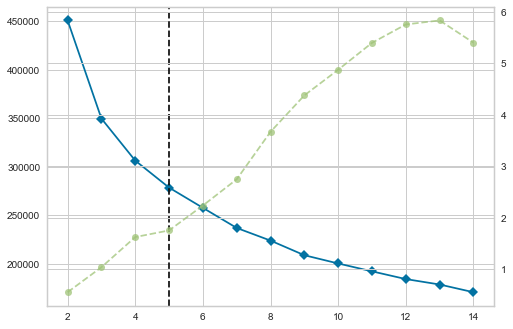

In [19]:

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

num_cols = ['review_aroma', 'review_appearance', 'review_palate', 'review_taste']

X_main_scaled_copy = X_main_scaled.copy()

model = KElbowVisualizer(KMeans(), k=(2,15))
model.fit(X_main_scaled_copy[num_cols])

n_cluster = model.elbow_value_
n_cluster


### 9. Gaussian Mixture - Add new feature  "cluster_kmean"

In [20]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_cluster, random_state=8)
gmm.fit(X_main_scaled_copy[num_cols])

GaussianMixture(n_components=5, random_state=8)

In [21]:
cluster_prediction = gmm.predict(X_main_scaled_copy[num_cols])

In [22]:
X_main_scaled_copy['cluster_kmean'] = cluster_prediction

In [23]:
obs = pd.DataFrame(X_main_scaled_copy.iloc[0][num_cols]).transpose()
gmm.predict(obs)

array([2], dtype=int64)

In [24]:
X_main_scaled_copy.head()

,review_aroma,review_appearance,review_palate,review_taste,brewery_name,beer_style,cluster_kmean
0,-2.681870,-2.343407,-3.511963,-3.362068,Vecchio Birraio,65,2
1,-1.940711,-1.500041,-1.228480,-1.228070,Vecchio Birraio,51,0
2,-1.940711,-1.500041,-1.228480,-1.228070,Vecchio Birraio,59,0
3,-1.199551,-0.656674,-1.989641,-1.228070,Vecchio Birraio,61,1
4,1.023926,0.186692,0.293842,0.905928,Caldera Brewing Company,9,3


### 10. One Hot Encoding the feature - "brewery_name"

In [25]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

## Re-assign the brewey_name into the dataframe to do OHE,because it was removed during the scaling and k-means clustering
X_main_scaled_kmean = X_main_scaled_copy.copy()
X_main_scaled_kmean['brewery_name'] = X_main['brewery_name']

X_main_cat_enc = pd.DataFrame(ohe.fit_transform(X_main_scaled_kmean[['brewery_name']]))
X_main_cat_enc.columns = ohe.get_feature_names(['brewery_name'])

# Drop the original column brewery_name as the encoded columns are inplace
X_main_scaled_kmean.drop('brewery_name', axis = 1, inplace=True)
X_main_scaled_encoded = pd.concat([X_main_scaled_kmean, X_main_cat_enc], axis=1)

## Re-Add the beer_style_encoded ahead of splitting
X_main_scaled_encoded['beerstyle_encoded'] = y_main
X_main_scaled_encoded.head()

,review_aroma,review_appearance,review_palate,review_taste,beer_style,cluster_kmean,brewery_name_10 Barrel Brewing Co.,brewery_name_16 Mile Brewing Company,brewery_name_1702 / The Address Brewing Co.,brewery_name_4th Street Brewing Company,...,brewery_name_Yellowhammer Brewing,brewery_name_Yellowstone Valley Brewing Co.,brewery_name_Zago S.r.l.,brewery_name_Zak&#322;ady Piwowarskie w Le&#380;ajsku S.A.,brewery_name_Zerodegrees Bristol,brewery_name_Zum Löwenbräu,brewery_name_Zum Stiefel,brewery_name_Zweite Schweriner Schlossbrauerei,brewery_name_Ölgerð Reykjavíkur,beerstyle_encoded
0,-2.681870,-2.343407,-3.511963,-3.362068,65,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65
1,-1.940711,-1.500041,-1.228480,-1.228070,51,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51
2,-1.940711,-1.500041,-1.228480,-1.228070,59,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59
3,-1.199551,-0.656674,-1.989641,-1.228070,61,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61
4,1.023926,0.186692,0.293842,0.905928,9,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [26]:
X_main_scaled_encoded = X_main_scaled_encoded.drop('beer_style', axis = 1)

### 11. Split the encoded and scaled 200k dataset into Train-Val-Test sets

In [27]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets_random(X_main_scaled_encoded, "beerstyle_encoded", test_ratio=0.2, to_numpy=True)

In [28]:
print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

(120000, 770)


###  12. Baseline Model

In [23]:
from src.models.null import NullModel

base_model = NullModel(target_type="classification")
y_base = base_model.fit_predict(y_train)

from src.models.performance import print_reg_perf
print_reg_perf(y_base, y_train, set_name='Training')

RMSE Training: 1586.89245
MAE Training: 26.471083333333333


### 13. Load Pytorch Dataset

In [29]:
from src.models.pytorch import PytorchDataset

train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

### 14. Build Neural Net Model

In [30]:
import torch as torch
import torch.nn as nn
from src.models.pytorch import PytorchMultiClass_2
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2

model = PytorchMultiClass_2(X_train.shape[1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from src.models.pytorch import get_device, predict
device = get_device()
model.to(device)

PytorchMultiClass_2(
  (layer_1): Linear(in_features=770, out_features=70, bias=True)
  (layer_2): Linear(in_features=70, out_features=70, bias=True)
  (layer_out): Linear(in_features=70, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [33]:
from src.models.pytorch import train_classification, test_classification

N_EPOCHS = 10
BATCH_SIZE = 200

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
    valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)

    print(f'Epoch: {epoch}')
    print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')
    print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

Epoch: 0
	(train)	|	Loss: 0.0227	|	Acc: 12.3%
	(valid)	|	Loss: 0.0227	|	Acc: 12.5%
Epoch: 1
	(train)	|	Loss: 0.0227	|	Acc: 12.3%
	(valid)	|	Loss: 0.0227	|	Acc: 12.9%
Epoch: 2
	(train)	|	Loss: 0.0227	|	Acc: 12.3%
	(valid)	|	Loss: 0.0227	|	Acc: 12.8%
Epoch: 3
	(train)	|	Loss: 0.0227	|	Acc: 12.5%
	(valid)	|	Loss: 0.0227	|	Acc: 12.6%
Epoch: 4
	(train)	|	Loss: 0.0227	|	Acc: 12.4%
	(valid)	|	Loss: 0.0227	|	Acc: 12.6%
Epoch: 5
	(train)	|	Loss: 0.0227	|	Acc: 12.3%
	(valid)	|	Loss: 0.0227	|	Acc: 12.5%
Epoch: 6
	(train)	|	Loss: 0.0227	|	Acc: 12.3%
	(valid)	|	Loss: 0.0227	|	Acc: 12.5%
Epoch: 7
	(train)	|	Loss: 0.0227	|	Acc: 12.3%
	(valid)	|	Loss: 0.0227	|	Acc: 12.5%
Epoch: 8
	(train)	|	Loss: 0.0227	|	Acc: 12.4%
	(valid)	|	Loss: 0.0227	|	Acc: 12.6%
Epoch: 9
	(train)	|	Loss: 0.0227	|	Acc: 12.5%
	(valid)	|	Loss: 0.0227	|	Acc: 12.5%


In [34]:
test_loss, test_acc =  test_classification(test_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
print(f'\tLoss: {test_loss:4f}\t | \tAccuracy:{test_acc:.1f}')

	Loss: 0.022666	 | 	Accuracy:0.1


In [35]:
torch.save(model, "../models/pytorch_multi_beer_type_prediction_nn_kmeans_layer1_5features.pt")

In [36]:
import torch as torch
import os
import sys
sys.path.append(os.path.abspath('../'))

model = torch.load('../models/pytorch_multi_beer_type_prediction_nn_kmeans_layer1_5features.pt', encoding='ascii')
model

PytorchMultiClass_2(
  (layer_1): Linear(in_features=770, out_features=70, bias=True)
  (layer_2): Linear(in_features=70, out_features=70, bias=True)
  (layer_out): Linear(in_features=70, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)

In [37]:
from torch import Tensor
from src.models.pytorch import predict

# features=['brewery_name','review_aroma','review_appearance', 'review_palate', 'review_taste']
# query_data = pd.DataFrame([{5,7,8,3,5,4}], columns = features )
query_data =pd.DataFrame( {'brewery_name': [6, 6,8,9 ],
        'review_aroma': [22000,25000,27000,35000],
        'review_appearance': [7,8,4,3],
        'review_palate': [3,4,2,5],
        'review_taste': [1,3,5,6]
        })

#query_data_tensor = torch.tensor(query_data.to_numpy())

prediction = predict(query_data, model)
# #obs = pd.DataFrame(X_main_scaled_copy.iloc[0][num_cols]).transpose()
# prediction

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x5 and 770x70)